<a href="https://colab.research.google.com/github/PaletteofDesign/intro_to_gradient_boosting/blob/main/intro_to_gradient_boosting_assignment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Gradient Boosting

![gradient boosting image](https://media.geeksforgeeks.org/wp-content/uploads/20200721214745/gradientboosting.PNG)

Image thanks to [Geeks for Geeks](https://www.geeksforgeeks.org/ml-gradient-boosting/)

In this assignment you will:
1. import and prepare a dataset for modeling
2. test and evaluate 3 different boosting models and compare the fit times of each.
3. tune the hyperparameters of the best model to reduce overfitting and improve performance.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

In this assignment you will be working with census data.  Your goal is to predict whether a person will make more or less than $50k per year in income.

The data is available [here](https://drive.google.com/file/d/1drlRzq-lIY7rxQnvv_3fsxfIfLsjQ4A-/view?usp=sharing)

In [3]:
f = '/content/drive/MyDrive/census_income - census_income.csv'
df = pd.read_csv(f)
df.head()

,Unnamed: 0,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Prepare your dataset for modeling.

Remember to: 
1. Check for missing data or bad data.
2. Check your target class balance
3. Any other data preparation you think might improve your model performance 
4. Dummy encode categorical values.  You can find the names of all of the columns with categorical data with the following code:
`categorical_cols = X.select_dtypes(include='object').columns`.

[Here is the documentaion](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html) for `df.select_dtypes()`

In [4]:
df['income-class'].value_counts(normalize=True)

<=50K    0.75919
>50K     0.24081
Name: income-class, dtype: float64

In [5]:
categorical_cols = df.select_dtypes(include='object').columns
print(categorical_cols)

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income-class'],
      dtype='object')


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      32561 non-null  int64 
 1   age             32561 non-null  int64 
 2   workclass       32561 non-null  object
 3   education       32561 non-null  object
 4   marital-status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  income-class    32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,32561.0,16280.000000,9399.695394,0.0,8140.0,16280.0,24420.0,32560.0
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


In [8]:
df.duplicated().sum()

0

In [9]:
df.nunique()

Unnamed: 0        32561
age                  73
workclass             9
education            16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       42
income-class          2
dtype: int64

In [10]:
df.drop(columns='Unnamed: 0', inplace=True)
df[0:5]

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [11]:
df.isin(['?']).sum()

age                  0
workclass         1836
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income-class         0
dtype: int64

In [12]:
# Replaced ? with nan to use dropna to remove.
df.replace(to_replace='?', value=np.nan, inplace=True)
df.dropna(inplace=True)
df.head(20)

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,9th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,Masters,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [13]:
df = pd.get_dummies(df, columns=['workclass', 'education', 'marital-status', 'occupation', 
                             'relationship', 'race', 'sex', 'native-country', 'income-class'], drop_first=True)

In [14]:
df['income-class_>50K'].value_counts(normalize=True)

0    0.751078
1    0.248922
Name: income-class_>50K, dtype: float64

In [15]:
X = df.drop(columns='income-class_>50K')
y = df['income-class_>50K']
print(X.shape)
print(y.shape)

(30162, 94)
(30162,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [17]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [18]:
pca = PCA(.95)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [19]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

You have a lot of columns now, but that's okay.  We aren't doing any clustering algorithms in this assignment.  If we were, you would want to try to reduce the number of features by using PCA that you learned last week.  You could try that anyway if you want the practice.  It might even help!

Otherwise let's move on to fitting our first boosting model.

# eXtreme Gradient Boosting
We are going to compare both metrics and fit times for our models.  Notice the 'cell magic' in the top of the cell below.  By putting `%%time` at the top of a notebook cell, we can tell it to output how long that cell took to run.  We can use this to compare the speed of each of our different models.  Fit times can be very important for models in deployment, especially with very large dataset and/or many features.

Instantiate an eXtreme Gradient Boosting Classifier (XGBClassifier) below, fit it, and print out a classification report.  Take note of the accuracy, recall, precision, and f1-score, as well as the run time of the cell to compare to our next models.

In [20]:
# Model ran with pca data
%%time
xgb = XGBClassifier()
xgb.fit(X_train_pca, y_train)

CPU times: user 624 ms, sys: 107 ms, total: 731 ms
Wall time: 651 ms


In [21]:
# Model ran with pca data
print('Training accuracy:', xgb.score(X_train_pca, y_train))
print('Testing accuracy:', xgb.score(X_test_pca, y_test))

Training accuracy: 0.8191061403120994
Testing accuracy: 0.8205808248242938


In [22]:
# Model ran with pca data
y_pred = xgb.predict(X_test_pca)

In [23]:
# Model ran with pca data
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      5662
           1       0.97      0.29      0.45      1879

    accuracy                           0.82      7541
   macro avg       0.89      0.64      0.67      7541
weighted avg       0.85      0.82      0.78      7541



In [24]:
# Model ran without pca data
%%time
xgb = XGBClassifier()
xgb.fit(X_train_sc, y_train)

CPU times: user 4.92 s, sys: 43.6 ms, total: 4.96 s
Wall time: 4.96 s


In [25]:
# Model ran without pca data
print('Training accuracy:', xgb.score(X_train_sc, y_train))
print('Testing accuracy:', xgb.score(X_test_sc, y_test))

Training accuracy: 0.8592900402281066
Testing accuracy: 0.8661981169606153


In [26]:
# Model ran without pca data
y_pred = xgb.predict(X_test_sc)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.91      5662
           1       0.82      0.59      0.69      1879

    accuracy                           0.87      7541
   macro avg       0.85      0.78      0.80      7541
weighted avg       0.86      0.87      0.86      7541



Which target class is your model better at predicting?  Is it significantly overfit?

# More Gradient Boosting

Now fit and evaluate a Light Gradient Boosting Machine and a the Scikit Learn (sklearn) gradient boost model.  Remember to use the `%%time` cell magic command to get the run time.

## LightGBM

In [27]:
%%time
lgbm = LGBMClassifier()
lgbm.fit(X_train_pca, y_train)

CPU times: user 206 ms, sys: 13.9 ms, total: 220 ms
Wall time: 220 ms


In [28]:
print('Training accuracy:', lgbm.score(X_train_pca, y_train))
print('Testing accuracy:', lgbm.score(X_test_pca, y_test))

Training accuracy: 0.8119004464877768
Testing accuracy: 0.8136851876408965


In [29]:
# Model ran with pca data
y_pred = lgbm.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      5662
           1       0.89      0.29      0.44      1879

    accuracy                           0.81      7541
   macro avg       0.85      0.64      0.66      7541
weighted avg       0.83      0.81      0.78      7541



In [30]:
%%time
lgbm = LGBMClassifier()
lgbm.fit(X_train_sc, y_train)

CPU times: user 1.53 s, sys: 32.8 ms, total: 1.56 s
Wall time: 1.56 s


In [31]:
print('Training accuracy:', lgbm.score(X_train_sc, y_train))
print('Testing accuracy:', lgbm.score(X_test_sc, y_test))

Training accuracy: 0.8806418814376022
Testing accuracy: 0.8737567961808779


In [32]:
# Model ran without pca data
# Best performance
y_pred = lgbm.predict(X_test_sc)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      5662
           1       0.80      0.66      0.72      1879

    accuracy                           0.87      7541
   macro avg       0.85      0.80      0.82      7541
weighted avg       0.87      0.87      0.87      7541



## GradientBoostingClassifier

In [33]:
%%time
gbm = GradientBoostingClassifier()
gbm.fit(X_train_pca, y_train)

CPU times: user 1.11 s, sys: 10.8 ms, total: 1.12 s
Wall time: 1.12 s


In [34]:
print('Training accuracy:', gbm.score(X_train_pca, y_train))
print('Testing accuracy:', gbm.score(X_test_pca, y_test))

Training accuracy: 0.8224216436054993
Testing accuracy: 0.8233656013791274


In [35]:
# Model ran with pca data
y_pred = gbm.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      5662
           1       0.96      0.30      0.46      1879

    accuracy                           0.82      7541
   macro avg       0.89      0.65      0.68      7541
weighted avg       0.85      0.82      0.79      7541



In [36]:
%%time
gbm = GradientBoostingClassifier()
gbm.fit(X_train_sc, y_train)

CPU times: user 4.61 s, sys: 13 ms, total: 4.63 s
Wall time: 4.65 s


In [37]:
print('Training accuracy:', gbm.score(X_train_sc, y_train))
print('Testing accuracy:', gbm.score(X_test_sc, y_test))

Training accuracy: 0.8628707837849786
Testing accuracy: 0.8683198514785837


In [38]:
# Model ran without pca data
y_pred = gbm.predict(X_test_sc)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      5662
           1       0.82      0.61      0.70      1879

    accuracy                           0.87      7541
   macro avg       0.85      0.78      0.81      7541
weighted avg       0.86      0.87      0.86      7541



# Tuning Gradient Boosting Models

Tree-based gradient boosting models have a LOT of hyperparameters to tune.  Here are the documentation pages for each of the 3 models you used today:

1. [XGBoost Hyperparameter Documentation](https://xgboost.readthedocs.io/en/latest/parameter.html)
2. [LightGBM Hyperparameter Documentation](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
3. [Scikit-learn Gradient Boosting Classifier Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Choose the model you felt performed the best when comparing multiple metrics and the runtime for fitting, and use GridSearchCV to try at least 2 different values each for 3 different hyper parameters in boosting model you chose.

See if you can create a model with an accuracy between 86 and 90.


In [39]:
params = {'n_estimators': [100, 150, 200, 250, 300], 'max_depth': [2, 3, 4, 5], 'learning_rate':[0.4, 0.3, 0.2, 0.1]}
gs = GridSearchCV(LGBMClassifier(), params, cv=3, return_train_score=True)
gs.fit(X_train_sc, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.4, 0.3, 0.2, 0.1],
                         'max_

In [40]:
gs.best_params_

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}

In [41]:
gs.best_score_

0.8671588537333957

In [42]:
#Used my own values and got a better score.
lgbm = LGBMClassifier(n_estimators=200, max_depth=5)
lgbm.fit(X_train_sc, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [43]:
print('Training accuracy:', lgbm.score(X_train_sc, y_train))
print('Testing accuracy:', lgbm.score(X_test_sc, y_test))

Training accuracy: 0.8782989257769329
Testing accuracy: 0.8740220129956239


# Evaluation

Evaluate your model using a classifiation report and/or a confusion matrix.  Explain in text how your model performed in terms of precision, recall, and it's ability to predict each of the two classes.  Also talk about the benefits or drawbacks of the computation time of that model.

In [44]:
y_pred = lgbm.predict(X_test_sc)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      5662
           1       0.80      0.65      0.72      1879

    accuracy                           0.87      7541
   macro avg       0.85      0.80      0.82      7541
weighted avg       0.87      0.87      0.87      7541



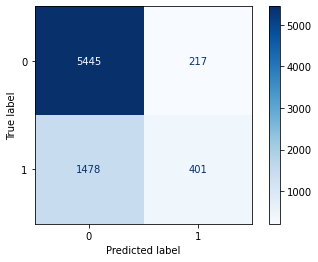

In [45]:
plot_confusion_matrix(lgbm, X_test, y_test, cmap = 'Blues', values_format='d');

After evaluating the models, the one that seems to be the best performer is the lgbm model. Between the results and the speed it was my top choice. The precision and recal were close between the lgbm and gbm models. However, accuracy was better with the lgbm model. The percision in the classification report shows the percentage of positive identifications that were correct and the recall shows the proportion of actual positives corectly predicted. 

# Conclusion

In this assignment you practiced:
1. data cleaning
2. instantiating, fitting, and evaluating boosting models using multiple metrics
3. timing how long it takes a model to fit and comparing run times between multiple models
4. and choosing a final model based on multiple metrics.

